# Librerías

In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!mkdir /root/tensorflow_datasets
!cp -r /content/drive/MyDrive/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/

# Data

In [31]:
file = '2022_08_11-02:35:11_spiral_mask_epochs:200_size:128_th:3'

NUM_EPOCHS = 150
size = 128
mask = 'spiral_mask'
threshold = 4
BATCH_SIZE = 32

## Useful functions

In [32]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")

    return input_image, input_mask 


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
  
    return input_image


def binary_mask(input_mask):
    th = threshold
    input_mask = tf.where(input_mask<th, tf.zeros_like(input_mask), tf.ones_like(input_mask))
    
    return input_mask
    
    
def load_image_train(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def display(display_list):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

## Learning data

In [33]:
path = '/content/drive/MyDrive/Galaxy Segmentation Project/Modelos/'
results = pd.read_csv(f'{path}{file}.csv')

## Model data

In [37]:
ds = tfds.load('galaxy_zoo3d', split=['train[:75%]', 'train[75%:]'])
ds_test = ds[1]

min_vote = 3
ds_test_spirals = ds_test.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)
ds_test_bars = ds_test.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)

test_dataset = ds_test_spirals.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

# Brazos: 1100, 539. Barras: 800, 453
validation_batches = test_dataset.take(1100).batch(BATCH_SIZE)
test_batches = test_dataset.skip(1100).take(539).batch(BATCH_SIZE)

unet_model = load_model(f'{file}.h5')

OSError: ignored

# Learning curves

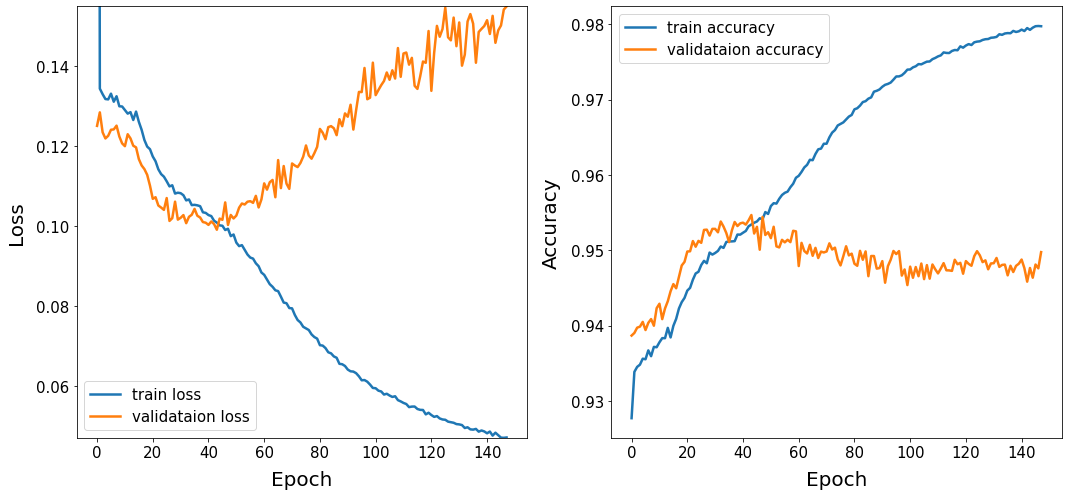

In [38]:
def display_learning_curves(results):

    loss = results["loss"]
    val_loss = results["val_loss"]

    acc = results["accuracy"]
    val_acc = results["val_accuracy"]

    epochs_range = range(len(results))

    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    ax[0].plot(epochs_range, loss, label="train loss", linewidth=2.5)
    ax[0].plot(epochs_range, val_loss, label="validation loss", linewidth=2.5)
    ax[0].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[0].set_ylabel("Loss", fontsize=20, labelpad=10)
    ax[0].set_ylim(min(min(loss), min(val_loss)), max(max(loss[1:]), max(val_loss[1:])))
    ax[0].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc="best", fontsize=15)

    ax[1].plot(epochs_range, acc, label="train accuracy", linewidth=2.5)
    ax[1].plot(epochs_range, val_acc, label="validation accuracy", linewidth=2.5)
    ax[1].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[1].set_ylabel("Accuracy", fontsize=20, labelpad=10)
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].legend(loc="best", fontsize=15)

    fig.tight_layout()
    fig.show()


display_learning_curves(results)

# Predicciones

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
      print('Matriz de confusión:')
      print(confusion_matrix(create_mask(pred_mask).numpy().reshape(-1), mask[0].numpy().reshape(-1)))
      

show_predictions(test_batches.skip(3), 15)